This notebook goes through how to define **geometry**, apply **Euclidian transformations**, apply **modifications**, **create new geometry from the existing geometry**, and how to **visualize the results**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom import GenericGeometry
from spomso.cores.geom_3d import Box

# PARAMETERS

In [2]:
# size of the volume
co_size = 4, 4, 2
# resolution of the volume
co_resolution = 100, 100, 100

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Create a **box** with side lengths **1**, **0.5**, and **0.25**

In [4]:
box = Box(1, 0.5, 0.25)

## LOCATION

Move the center of the geometry (**box**) by the vector **(0.1, 1, -0.25)**:

In [5]:
box.move((0.1, 1, -0.25))

Since the **box** is originally centered at zero the center of box is moved to **(0.1, 1, -0.25)**.

Geometry can be moved to a specific location with the following function (in this case to **(1, 1, 0.5)**):

In [6]:
box.set_location((1, 1, 0.5))

**set_location** overrides all previous **set_location** and **move** calls.

Move the **box** back to the origin:

In [7]:
box.move((-1, -1, -0.5))

## SCALE

Rescale the object by a factor of **2**, which means the **box** will now have side lengths of **2**, **1**, **0.5**:

In [8]:
box.rescale(2)

Rescale the **box** once again by a factor of **1.5**:

In [9]:
box.rescale(1.5)

The side lengths of the **box** are **original_side_lengths $\cdot$ 2 $\cdot$ 1.5**.

The rescaling factor can be set to a specific value with:

In [10]:
box.set_scale(1.5)

**set_scale** overrides all previous rescale and **set_scale** calls, therefore the side lengths are now **1.5**, **0.75**, and **0.375**.

**Rescale** the side lengths back to **1**, **0.5**, and **0.25**:

In [11]:
box.rescale(2/3)

## ROTATION

Rotate the **box** around the **(1, 1, 0)** axis for **90°**:

In [12]:
box.rotate(np.pi/2, (1, 1, 0))

The **rotate** method can also accept a **rotation matrix** as an input.

**Rotate** the **box** around the **(-1, 1, 0)** axis for **-45°**:

In [13]:
box.rotate(-np.pi/4, (-1, 1, 0))

**Rotate** the **box** around the **z-axis** for **45°**:

In [14]:
box.rotate(np.pi/4, (0, 0, 1))

Set the **rotation** to a specific **angle** and **axis**. In this case for **30°** around the **z-axis**:

In [15]:
box.set_rotation(np.pi/6, (0, 0, 1))

**set_rotation** overrides all previous **rotate** or **set_rotation** calls.

**Rotate** the **box** back to its original orientation:

In [16]:
box.rotate(-np.pi/6, (0, 0, 1))

## SHOW TRANSFORMATIONS

To see the applied **Euclidian transformations** use:

In [17]:
applied_transformations = box.transformations
print("Euclidian Transformations:", applied_transformations)

Euclidian Transformations: ['move', 'set_location', 'move', 'rescale', 'rescale', 'set_scale', 'rescale', 'rotate', 'rotate', 'rotate', 'set_rotation', 'rotate']


To see the **location** of the geometry use:

In [18]:
center = box.center
print("Position of the rectangle:", center)

Position of the rectangle: [0. 0. 0.]


To see the **scaling factor** applied to the geometry use:

In [19]:
scale = box.scale
print("Scaling of the rectangle:", scale)

Scaling of the rectangle: 1.0


To see the **rotation matrix** applied to the geometry use:

In [20]:
rotation_matrix = box.rotation_matrix
print("Rotation matrix of the rectangle:", rotation_matrix)

Rotation matrix of the rectangle: [[1.00000000e+00 7.43708407e-18 0.00000000e+00]
 [7.43708407e-18 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## NOTE

The **Euclidean transformations** are always applied after **modifications**. For example:

Apply a **rotation** of **45°** around the **z-axis**:

In [21]:
box.rotate(np.pi/4, (0, 0, 1))

Apply **mirroring** on the **x-axis**.  The original rectangle will be located at **(1, 0, 0)** and its mirror image at **(-1, 0, 0)**:

In [22]:
box.mirror((-1, 0, 0), (1, 0, 0))

<function spomso.cores.modifications.ModifyObject.mirror.<locals>.new_geo_object(co, *params)>

The **rotation** was called before the **mirror** modification but the **rotation** is applied to the geometry after the **mirroring**.

To apply the modifications after the transformations a new object has to be crated:

In [23]:
box = GenericGeometry(box.propagate)

Apply the **mirror** operation once more, but this time along the **y-axis**:

In [24]:
box.mirror((0, -0.5, 0), (0, 0.5, 0))

<function spomso.cores.modifications.ModifyObject.mirror.<locals>.new_geo_object(co, *params)>

In certain cases it does not matter if the **Euclidian transformations** are applied after the **modifications**. As a rule of thumb, this is true for **modifications** where the location of the geometry does not change, This is true for **modifications** such as **mirror**, **repetitions**, and **instancing** modifications.

## EVALUATE

Evaluate the SDF of the **box** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [25]:
box_pattern = box.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [26]:
if show_midplane:
    field = smarter_reshape(box_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(box_pattern, 0)

# PLOT

Drawing results...


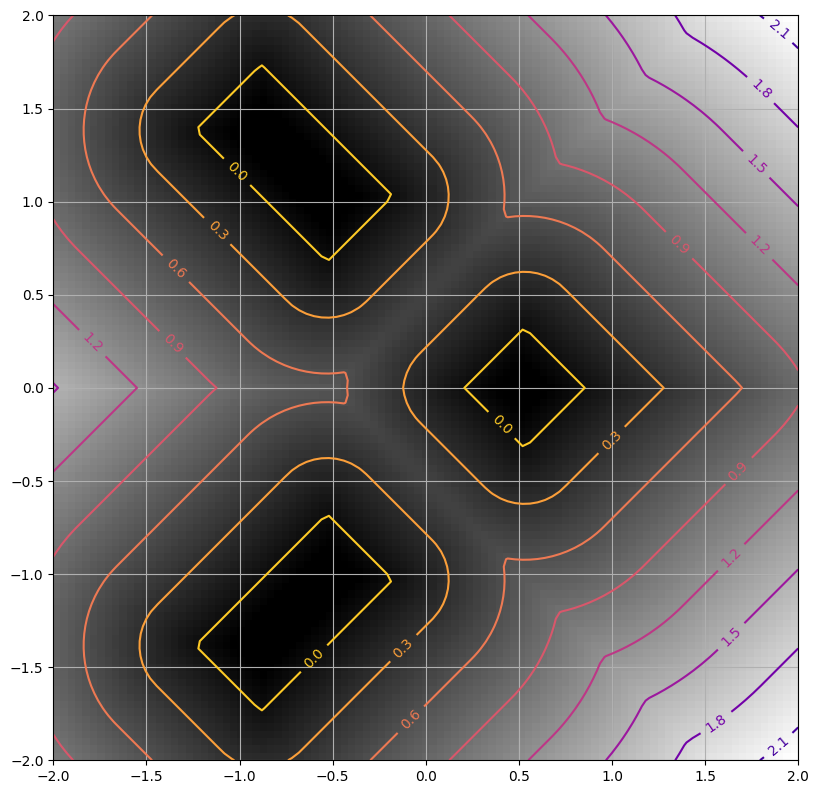

In [27]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :, co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, :, co_resolution[2]//2].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == 0
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :, co_resolution[2]//2],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [28]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=box_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()